In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/파이썬 데이터 분석 실무 테크닉 100/4장'

/content/drive/MyDrive/파이썬 데이터 분석 실무 테크닉 100/4장


# 31: 데이터를 읽어 들이고 확인하자

In [3]:
import pandas as pd

uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [4]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

# 32: 클러스터링으로 회원을 그룹화하자
- 이용 이력을 이용해서 그룹화하며, 정해진 정답이 없기 때문에 비지도학습 클러스터링을 이용한다.
- K-mean 클러스터링
    - 그룹화하고자 하는 수를 미리 지정해야한다.
    - mean, median, max, min은 1~8 사이의 값인 반면, membership_period의 최댓값은 47이다. membership_period에 의해 결과가 좌지우지되기 때문에 표준화를 해야한다.

In [5]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 3 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


# 33: 클러스터링 결과를 분석하자

In [7]:
customer_clustering.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [8]:
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


# 34: 클러스터링 결과를 가시화하자
- 주성분 분석으로 차원을 축소한다.

In [9]:
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

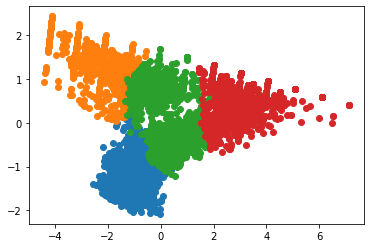

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

# 35: 클러스터링 결과를 바탕으로 탈퇴 회원의 경향을 파악하자

In [11]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [12]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


# 36: 다음 달의 이용 횟수 예측을 위해 데이터를 준비하자

In [13]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id':'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [14]:
year_months = list(uselog_months['연월'].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['연월'] == year_months[i]]
    tmp.rename(columns={'count':'count_pred'}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-j]]
        del tmp_before['연월']
        tmp_before.rename(columns={'count':'count_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [15]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


# 37: 특징이 되는 변수를 추가하자

In [16]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [17]:
# 연월과 start_date의 차이를 이용해 회원 기간을 월 단위로 작성
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])
from dateutil.relativedelta import relativedelta
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months
predict_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


# 38: 다음 달 이용 횟수를 예측하는 모델을 구축하자
- sklearn의 LinearRegression(선형회귀모델)을 이용한다.

In [18]:
predict_data = predict_data.loc[predict_data['start_date']>=pd.to_datetime('20180401')]

from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [19]:
# 정확도 검증
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6083214223731139
0.606105437292616


# 39: 모델에 기여하는 변수를 확인하자

In [20]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.coef_})
coef

,feature_names,coefficient
0,count_0,0.343691
1,count_1,0.183591
2,count_2,0.161399
3,count_3,0.194581
4,count_4,0.101669
5,count_5,0.051415
6,period,0.063528


# 40: 다음 달의 이용 횟수를 예측하자

In [21]:
# 각 회원의 이용 이력을 리스트에 저장하고 데이터를 작성한다.]
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [22]:
model.predict(x_pred)
# array([3.75080217, 1.93633829])
# 회원1은 3.7회, 회원2는 1.9회로 예측됐다.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([3.83643739, 1.92233089])

In [23]:
uselog_months.to_csv('use_log_months.csv', index=False)

# 새롭게 알게 된 지식
- from dateutil.relativedelta import relativedelta
- 정확도가 높은 예측 모델을 구축해도 그것이 어떤 모델인지를 이해하지 못하면 여러 가지 상황에서 설명할 수가 없다. 설명하지 못하면 현장에서도 납득하지 않아 도입이 지연되는 경우도 있다. 실제로 저자가 경험한 바에 의하면, 정확도가 높은 블랙박스 모델보다 정확도가 낮아도 설명이 가능한 모델이 사용되는 경우가 많다.
- model.coef_
    - 모델에 기여하는 변수를 확인할 수 있다.